# Bike Sharing Demand

## Problem Definition

The goal of this project is to combine historical usage patterns with weather data in order to predict hourly bike rental demand in the Capital Bikeshare program in Washington, D.C.

Using bike sharing systems, people rent a bike from a one location and return it to a different place on an as-needed basis. The process of obtaining membership, rental, and bike return is automated and tracked via a network of kiosks around the city. The duration of travel, departure location, arrival location, and time elapsed is recorded. 

As adverse weather may impact bike sharing usage, rental data is combined with measures of temperature, humidity, windspeed and weather conditions.

In [1]:
import pandas as pd
import numpy as np

from sklearn import metrics

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor


## Data

The data consists of hourly rental data spanning two years. The training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. 

datetime - hourly date + timestamp <br>
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter <br>
holiday - whether the day is considered a holiday <br>
workingday - whether the day is neither a weekend nor holiday <br>
weather -  <br>
1: Clear, Few clouds, Partly cloudy, Partly cloudy <br>
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist <br>
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds <br>
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog  <br>
temp - temperature in Celsius <br>
atemp - "feels like" temperature in Celsius <br>
humidity - relative humidity <br>
windspeed - wind speed <br>
casual - number of non-registered user rentals initiated <br>
registered - number of registered user rentals initiated <br>
count - number of total rentals <br>

In [3]:
# Update the value of dataPath for your computer:
dataPath = "E:/GitHub/W207_seney_swavola/data/"
parse_dates = ['datetime']
train_df = pd.read_csv(dataPath + 'train.csv', parse_dates=parse_dates)
test_df = pd.read_csv(dataPath + 'test.csv', parse_dates=parse_dates)

# Set target and predictors
target = ['count'] # or ['casual','registered'] for multivariate regression
predictors = ['datetime','season','holiday','workingday','weather','temp','atemp','humidity','windspeed']

X_train = train_df[predictors]
count_y_train = train_df[target]
X_test = test_df[predictors]


Let's take a look at the first few rows of the train data.

In [4]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
X_train.shape

(10886, 9)

## Exploratory Data Analysis - Features


#### What types of features are there?

In [6]:
X_train.dtypes.value_counts()

int64             5
float64           3
datetime64[ns]    1
dtype: int64

In [7]:
X_train.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
dtype: object

#### Are there missing values?

In [8]:
X_train.apply(lambda col: col.isnull()).sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

In [9]:
X_train.apply(lambda col: col.isnull()).mean().value_counts()

0.0    9
dtype: int64

There are no missing values in the data.

#### What is the distribution of the target?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C6C4240>]], dtype=object)

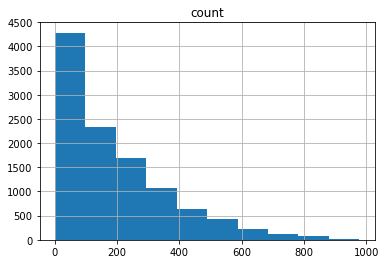

In [10]:
count_y_train.hist()

The data has a long tail to the right which may indicate outliers.

#### What are the distributions of the features?

Separate the datetime, continuous and categorical features. 

In [11]:
numeric_predictors = ['temp','atemp','humidity','windspeed']
categorical_predictors = ['season','holiday','workingday','weather']
date_time_predictors = ['datetime']

##### Numeric

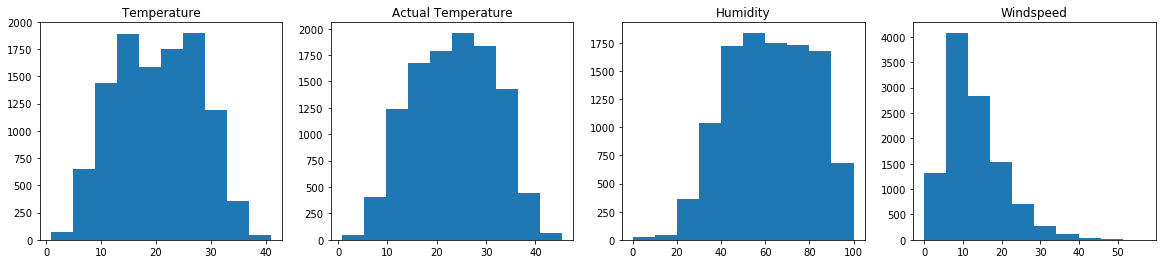

In [12]:
import matplotlib.pyplot as plt

X_train[numeric_predictors].describe().T

plt.figure(figsize=(20,4))
plt.subplot(1,4,1)
plt.hist(X_train['temp'])
plt.title("Temperature")
plt.subplot(1,4,2)
plt.hist(X_train['atemp'])
plt.title("Actual Temperature")
plt.subplot(1,4,3)
plt.hist(X_train['humidity'])
plt.title("Humidity")
plt.subplot(1,4,4)
plt.hist(X_train['windspeed'])
plt.title("Windspeed")

plt.show()


The numeric values are fairly normally distributed with different means. We should standardize the mean values to ensure that higher values such as humidity do not have more influence than lower values such as windspeed. Some models are sensitive to feature scale.

##### Categorical

In [13]:
for col in categorical_predictors:
    print col
    print X_train[col].value_counts().head()

season
4    2734
3    2733
2    2733
1    2686
Name: season, dtype: int64
holiday
0    10575
1      311
Name: holiday, dtype: int64
workingday
1    7412
0    3474
Name: workingday, dtype: int64
weather
1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64


The categorical features are numerically encoded. It may make more sense to use a category datatype.<br>
There is only one data point in the weather category 4 which is not surprising since only a hardy biker would bike share during severe weather conditions.

## Date Time Feature Creation

For our analysis we will need to separate the datetime feature into values for hour, day, month and year.

In [14]:
def extract_date_time(X):
    df = X.copy()
    hours = pd.DataFrame(X.apply(lambda row: (row[0].time()).hour, 1))
    days = pd.DataFrame(X.apply(lambda row: (row[0].date()).day, 1))
    months = pd.DataFrame(X.apply(lambda row: (row[0].date()).month, 1))
    years = pd.DataFrame(X.apply(lambda row: (row[0].date()).year, 1))
    df['hour'] = hours
    df['day'] = days
    df['month'] = months
    df['year'] = years
    df = df.drop(['datetime'], axis=1)
    return df 

X_train = extract_date_time(X_train)
print X_train.head()
X_test = extract_date_time(X_test)
print X_test.head()

date_time_predictors = ['hour','day','month','year']

   season  holiday  workingday  weather  temp   atemp  humidity  windspeed  \
0       1        0           0        1  9.84  14.395        81        0.0   
1       1        0           0        1  9.02  13.635        80        0.0   
2       1        0           0        1  9.02  13.635        80        0.0   
3       1        0           0        1  9.84  14.395        75        0.0   
4       1        0           0        1  9.84  14.395        75        0.0   

   hour  day  month  year  
0     0    1      1  2011  
1     1    1      1  2011  
2     2    1      1  2011  
3     3    1      1  2011  
4     4    1      1  2011  
   season  holiday  workingday  weather   temp   atemp  humidity  windspeed  \
0       1        0           1        1  10.66  11.365        56    26.0027   
1       1        0           1        1  10.66  13.635        56     0.0000   
2       1        0           1        1  10.66  13.635        56     0.0000   
3       1        0           1        1  10.66 

## Exploratory Data Analysis - Feature Relationships

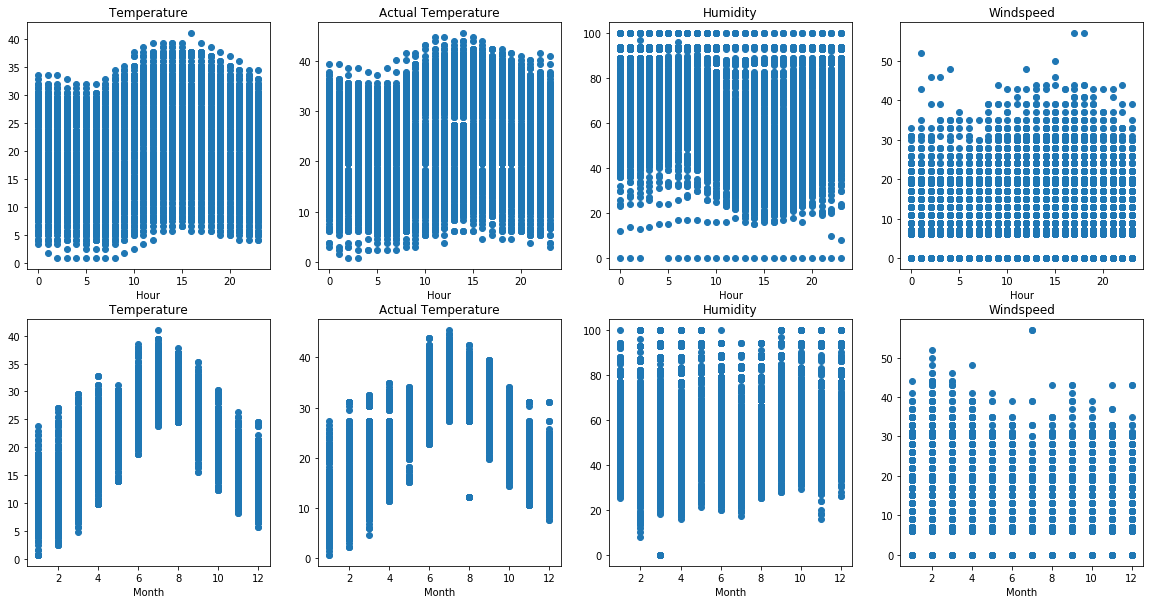

In [15]:
# Numeric weather features by hour
plt.figure(figsize=(20,10))
plt.subplot(2,4,1)
plt.scatter(X_train['hour'],X_train['temp'])
plt.xlabel('Hour')
plt.title("Temperature")
plt.subplot(2,4,2)
plt.scatter(X_train['hour'],X_train['atemp'])
plt.xlabel('Hour')
plt.title("Actual Temperature")
plt.subplot(2,4,3)
plt.scatter(X_train['hour'],X_train['humidity'])
plt.xlabel('Hour')
plt.title("Humidity")
plt.subplot(2,4,4)
plt.scatter(X_train['hour'],X_train['windspeed'])
plt.xlabel('Hour')
plt.title("Windspeed")

# Numeric weather features by month
plt.subplot(2,4,5)
plt.scatter(X_train['month'],X_train['temp'])
plt.xlabel('Month')
plt.title("Temperature")
plt.subplot(2,4,6)
plt.scatter(X_train['month'],X_train['atemp'])
plt.xlabel('Month')
plt.title("Actual Temperature")
plt.subplot(2,4,7)
plt.scatter(X_train['month'],X_train['humidity'])
plt.xlabel('Month')
plt.title("Humidity")
plt.subplot(2,4,8)
plt.scatter(X_train['month'],X_train['windspeed'])
plt.xlabel('Month')
plt.title("Windspeed")

plt.show()


There is a clear pattern to the temperature changes over the day and also over a year. Patterns to humidity and windspeed are more subtle and are almost the inverse of each other.

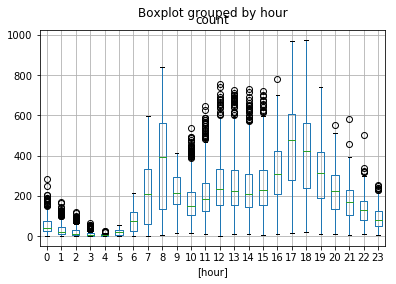

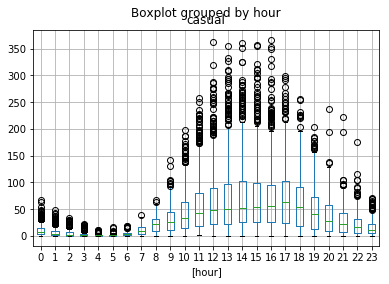

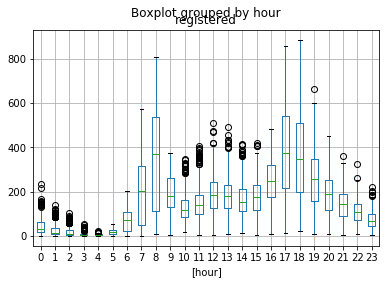

In [16]:
X_train_eda = X_train.copy()
X_train_eda['count'] = train_df['count']
X_train_eda['casual'] = train_df['casual']
X_train_eda['registered'] = train_df['registered']

# Boxplots of count/casual/registered by hour
X_train_eda.boxplot(column=['count'], by=['hour'])
X_train_eda.boxplot(column=['casual'], by=['hour'])
X_train_eda.boxplot(column=['registered'], by=['hour'])
#X_train_eda.boxplot(column=['count'], by=['workingday'])
#X_train_eda.boxplot(column=['count'], by=['season'])
#X_train_eda.boxplot(column=['count'], by=['weather'])


There are quite a few outlier values in the counts, especially the casual user counts. They appear to follow the same pattern as the mean, and do not look like random aberrations. We decided to keep them in the data set.

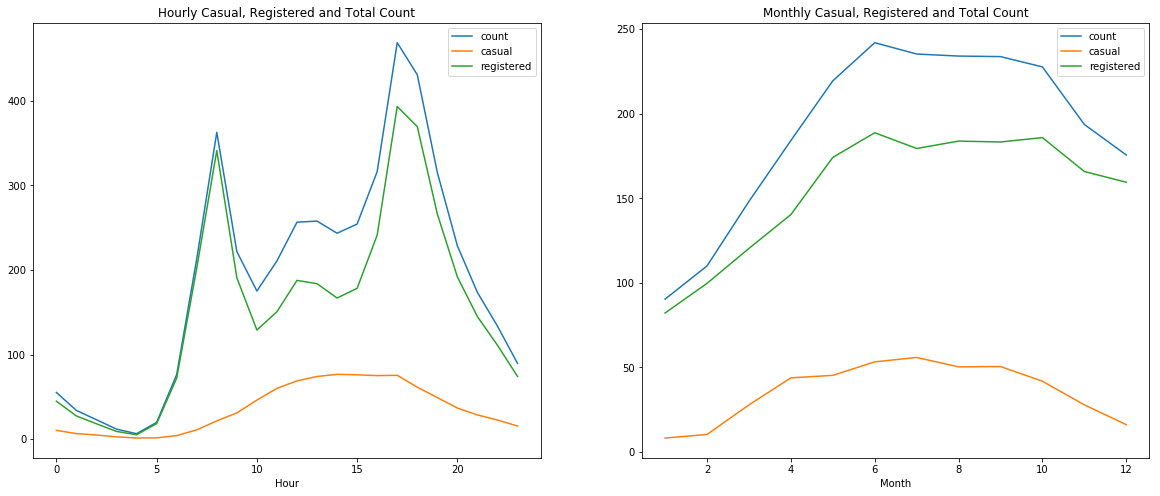

In [17]:
hourlyMeanCount = pd.DataFrame(X_train_eda.groupby(["hour"],sort=True)["count"].mean()).reset_index()
hourlyMeanCasual = pd.DataFrame(X_train_eda.groupby(["hour"],sort=True)["casual"].mean()).reset_index()
hourlyMeanReg = pd.DataFrame(X_train_eda.groupby(["hour"],sort=True)["registered"].mean()).reset_index()
monthlyMeanCount = pd.DataFrame(X_train_eda.groupby(["month"],sort=True)["count"].mean()).reset_index()
monthlyMeanCasual = pd.DataFrame(X_train_eda.groupby(["month"],sort=True)["casual"].mean()).reset_index()
monthlyMeanReg = pd.DataFrame(X_train_eda.groupby(["month"],sort=True)["registered"].mean()).reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(hourlyMeanCount['hour'],hourlyMeanCount['count'])
plt.plot(hourlyMeanCasual['hour'],hourlyMeanCasual['casual'])
plt.plot(hourlyMeanReg['hour'],hourlyMeanReg['registered'])
plt.xlabel('Hour')
plt.title("Hourly Casual, Registered and Total Count")
plt.legend()
plt.subplot(1,2,2)
plt.plot(monthlyMeanCount['month'],monthlyMeanCount['count'])
plt.plot(monthlyMeanCasual['month'],monthlyMeanCasual['casual'])
plt.plot(monthlyMeanReg['month'],monthlyMeanReg['registered'])
plt.xlabel('Month')
plt.title("Monthly Casual, Registered and Total Count")
plt.legend()
plt.show()

There are daily fluctuations in the count values as well as trends over the year.

                temp     atemp  humidity  windspeed     count    casual  \
temp        1.000000  0.984948 -0.064949  -0.017852  0.394454  0.467097   
atemp       0.984948  1.000000 -0.043536  -0.057473  0.389784  0.462067   
humidity   -0.064949 -0.043536  1.000000  -0.318607 -0.317371 -0.348187   
windspeed  -0.017852 -0.057473 -0.318607   1.000000  0.101369  0.092276   
count       0.394454  0.389784 -0.317371   0.101369  1.000000  0.690414   
casual      0.467097  0.462067 -0.348187   0.092276  0.690414  1.000000   
registered  0.318571  0.314635 -0.265458   0.091052  0.970948  0.497250   

            registered  
temp          0.318571  
atemp         0.314635  
humidity     -0.265458  
windspeed     0.091052  
count         0.970948  
casual        0.497250  
registered    1.000000  


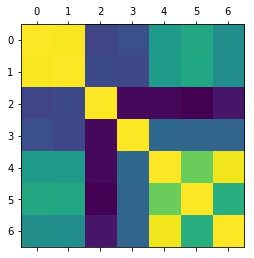

In [18]:
corr = X_train_eda[['temp','atemp','humidity','windspeed','count','casual','registered']].corr()
print corr
plt.matshow(corr)

The predictive features most highly correlated with count are temperature, actual temperature and humidity (negative correlation).<br>
There is a strong correlation between temperature and actual temperature.<br>
There is a negative correlation between humidty and windspeed. But only a small positive correlation between windspeed and count.<br>
Temperature and humidity have a stronger correlation with casual than with registered users.<br>
There is a stronger correlation between registered users and count than between casual users and count.

We may experiment with removing one of the temperature features.<br>
We expect that temperature and humidity would be significant predictive influencers.<br>
We will look at modelling the casual and registered users separately.

## Train and Dev Split

Split the train data into train and dev, using the last week of train data from each month for dev

In [19]:
dev_mask = X_train['day'] > 12
dev_idx = np.flatnonzero(dev_mask)
X_dev = X_train.iloc[dev_idx]
count_y_dev = count_y_train.iloc[dev_idx]


train_mask = X_train['day'] <= 12
train_idx = np.flatnonzero(train_mask)
X_train = X_train.iloc[train_idx]
count_y_train = count_y_train.iloc[train_idx]

In [20]:
print X_train.head()
print X_train.shape
print X_dev.head()
print X_dev.shape

   season  holiday  workingday  weather  temp   atemp  humidity  windspeed  \
0       1        0           0        1  9.84  14.395        81        0.0   
1       1        0           0        1  9.02  13.635        80        0.0   
2       1        0           0        1  9.02  13.635        80        0.0   
3       1        0           0        1  9.84  14.395        75        0.0   
4       1        0           0        1  9.84  14.395        75        0.0   

   hour  day  month  year  
0     0    1      1  2011  
1     1    1      1  2011  
2     2    1      1  2011  
3     3    1      1  2011  
4     4    1      1  2011  
(6878, 12)
     season  holiday  workingday  weather  temp  atemp  humidity  windspeed  \
277       1        0           1        1  5.74   6.06        59    19.0012   
278       1        0           1        1  5.74   6.06        50    19.0012   
279       1        0           1        1  5.74   6.06        50    23.9994   
280       1        0           1    

### Separating into Registered and Casual users

In [21]:
reg_target = ['registered'] 
casual_target = ['casual']

reg_y_train = train_df[reg_target]
casual_y_train = train_df[casual_target]

#print reg_y_train.head()
#print casual_y_train.head()

reg_y_dev = reg_y_train.iloc[dev_idx]
casual_y_dev = casual_y_train.iloc[dev_idx]

reg_y_train = reg_y_train.iloc[train_idx]
casual_y_train = casual_y_train.iloc[train_idx]

#print reg_y_dev.head()
#print casual_y_dev.head()


In [22]:
y_training_sets=[count_y_train,reg_y_train,casual_y_train]
y_dev_sets=[count_y_dev,reg_y_dev,casual_y_dev]

for i in y_training_sets:
    print "training set",i.head()

print "\n"
for i in y_dev_sets:
    print "dev set",i.head()
    

training set    count
0     16
1     40
2     32
3     13
4      1
training set    registered
0          13
1          32
2          27
3          10
4           1
training set    casual
0       3
1       8
2       5
3       3
4       0


dev set      count
277      7
278      2
279      2
280      3
281      4
dev set      registered
277           6
278           2
279           2
280           3
281           4
dev set      casual
277       1
278       0
279       0
280       0
281       0


## Processing

We will process the data as follows:
1. We will verify the data types of the features. Categorical and date/time features will be assigned to categorical datatype.
- Some learning algorithms are sensitive to scaling. We will normalize the numeric features to avoid giving undue weight to particular features.


### Datetime Feature Processing

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

#### Step 1: Select Date/Time Features

In [24]:
def select_datetime_features(X):
    return X[date_time_predictors]
datetime_selector = FunctionTransformer(select_datetime_features, validate=False)

#print datetime_selector.fit_transform(X_train).head()
print datetime_selector.fit_transform(X_train).iloc[:15,:]

    hour  day  month  year
0      0    1      1  2011
1      1    1      1  2011
2      2    1      1  2011
3      3    1      1  2011
4      4    1      1  2011
5      5    1      1  2011
6      6    1      1  2011
7      7    1      1  2011
8      8    1      1  2011
9      9    1      1  2011
10    10    1      1  2011
11    11    1      1  2011
12    12    1      1  2011
13    13    1      1  2011
14    14    1      1  2011


#### Step 2: Change to category
Categoricals are a pandas data type, which correspond to categorical variables in statistics: a variable, which can take on only a limited, and usually fixed, number of possible values

In [25]:
def ensure_datatype_dt(X):
    return X.apply(lambda col: col.astype("category"))

dt_datatype = FunctionTransformer(ensure_datatype_dt, validate=False)
print dt_datatype.fit_transform(datetime_selector.fit_transform(X_train)).head()

  hour day month  year
0    0   1     1  2011
1    1   1     1  2011
2    2   1     1  2011
3    3   1     1  2011
4    4   1     1  2011


#### Create the date time pipeline

In [26]:
datetime_pipeline = Pipeline(steps=[
    ('select', datetime_selector),
    ('datatype', dt_datatype)
])

In [27]:
print datetime_pipeline.fit_transform(X_train).iloc[:25]
print datetime_pipeline.fit_transform(X_train).shape

   hour day month  year
0     0   1     1  2011
1     1   1     1  2011
2     2   1     1  2011
3     3   1     1  2011
4     4   1     1  2011
5     5   1     1  2011
6     6   1     1  2011
7     7   1     1  2011
8     8   1     1  2011
9     9   1     1  2011
10   10   1     1  2011
11   11   1     1  2011
12   12   1     1  2011
13   13   1     1  2011
14   14   1     1  2011
15   15   1     1  2011
16   16   1     1  2011
17   17   1     1  2011
18   18   1     1  2011
19   19   1     1  2011
20   20   1     1  2011
21   21   1     1  2011
22   22   1     1  2011
23   23   1     1  2011
24    0   2     1  2011
(6878, 4)


### Numeric Feature Processing

For the continuous features, we use the following feature processing steps:
1. Scale features to normalized z-scores.


In [28]:
from sklearn.preprocessing import StandardScaler


#### Step 1: Select Numeric Features

In [29]:
def select_numeric_features(X):
    return X[numeric_predictors]
numeric_selector = FunctionTransformer(select_numeric_features, validate=False)

print numeric_selector.fit_transform(X_train).head()

   temp   atemp  humidity  windspeed
0  9.84  14.395        81        0.0
1  9.02  13.635        80        0.0
2  9.02  13.635        80        0.0
3  9.84  14.395        75        0.0
4  9.84  14.395        75        0.0


#### Step 2: Scale

In [30]:
numeric_scaler = StandardScaler()
print numeric_scaler.fit_transform(numeric_selector.fit_transform(X_train))[:5,:]

[[-1.25341598 -1.02725317  0.95883402 -1.52471699]
 [-1.35380836 -1.11294415  0.90839493 -1.52471699]
 [-1.35380836 -1.11294415  0.90839493 -1.52471699]
 [-1.25341598 -1.02725317  0.65619949 -1.52471699]
 [-1.25341598 -1.02725317  0.65619949 -1.52471699]]


#### Create the numeric pipeline

In [31]:
numeric_pipeline = Pipeline(steps=[
    ('select', numeric_selector),
    ('scale', numeric_scaler)
])

In [32]:
print numeric_pipeline.fit_transform(X_train)
print numeric_pipeline.fit_transform(X_train).shape

[[-1.25341598 -1.02725317  0.95883402 -1.52471699]
 [-1.35380836 -1.11294415  0.90839493 -1.52471699]
 [-1.35380836 -1.11294415  0.90839493 -1.52471699]
 ..., 
 [-0.95223883 -1.02725317 -0.50389955  0.53607839]
 [-0.95223883 -1.02725317 -0.50389955  0.29401413]
 [-1.05263121 -1.11294415 -0.30214319  0.29401413]]
(6878L, 4L)


### Categorical Feature Processing

#### Step 1: Select columns that correspond to categorical features

In [35]:
def select_categorical_features(X):
    return X[categorical_predictors]

categorical_selector = FunctionTransformer(select_categorical_features, validate=False)
print categorical_selector.fit_transform(X_train).head()

   season  holiday  workingday  weather
0       1        0           0        1
1       1        0           0        1
2       1        0           0        1
3       1        0           0        1
4       1        0           0        1


#### Step 2: Ensure that each feature has the correct data type

In [45]:
def ensure_datatype_cat(X):
    X1 = X.copy()
    return X1.apply(lambda col: col.astype('category'))

categorical_datatype = FunctionTransformer(ensure_datatype_cat, validate=False)
#print categorical_datatype.fit_transform(categorical_selector.fit_transform(X_train)).head()
#for col in categorical_predictors:
#    print col
#    print categorical_datatype.fit_transform(categorical_selector.fit_transform(X_train))[col]

#### Create the categorical pipeline

In [46]:
categorical_pipeline = Pipeline(steps=[
    ('select', categorical_selector),
    ('datatype', categorical_datatype)
])

In [47]:
print categorical_pipeline.fit_transform(X_train).head()
print categorical_pipeline.fit_transform(X_train).shape

  season holiday workingday weather
0      1       0          0       1
1      1       0          0       1
2      1       0          0       1
3      1       0          0       1
4      1       0          0       1
(6878, 4)


### Combine the Pipelines

In [48]:
def combine_pipeline(datetime_pipeline, categorical_pipeline, X_train_set):
    trans_train_dt = datetime_pipeline.fit_transform(X_train_set)
    trans_train_num = numeric_pipeline.fit_transform(X_train_set)
    trans_train_num_df = pd.DataFrame(trans_train_num, columns=numeric_predictors)
    trans_train_cat = categorical_pipeline.fit_transform(X_train_set)
    trans_train_dt.index = trans_train_num_df.index = trans_train_cat.index
    transformed_train = pd.concat([trans_train_dt,trans_train_num_df,trans_train_cat], axis=1)
    return transformed_train

In [49]:
#using pipeline fn
transformed_train = combine_pipeline(datetime_pipeline, categorical_pipeline,X_train)
transformed_dev = combine_pipeline(datetime_pipeline, categorical_pipeline,X_dev)
transformed_test = combine_pipeline(datetime_pipeline, categorical_pipeline,X_test)

In [50]:
predictors = date_time_predictors + numeric_predictors + categorical_predictors
print predictors

['hour', 'day', 'month', 'year', 'temp', 'atemp', 'humidity', 'windspeed', 'season', 'holiday', 'workingday', 'weather']


## Score

Kaggle uses the Root Mean Squared Logarithmic Error in its evaluation of the test data, so we will use the same algorithm with our dev predictions.

In [51]:
def rmsle(y, y_hat):
    log_y = np.nan_to_num(np.array([np.log(i + 1) for i in y]))
    log_y_hat = np.nan_to_num(np.array([np.log(i + 1) for i in y_hat]))
    calc = (log_y - log_y_hat) ** 2
    return np.sqrt(np.mean(calc))

rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

## Output Generator

In [52]:
def CSV_Output(predict_series,output_name,X_test=test_df):
    result = pd.DataFrame({
        'datetime': X_test['datetime'],
        'count': predict_series[:].astype(int)
    })
    result = result[['datetime','count']]

    filename=output_name+"_output.csv"

    result.to_csv(dataPath + filename, header=True, index=False)

## Modelling

### Linear Regression

Linear regression fits a linear model to the data by minimizing the sum of the squared residuals between the regression line and the actual data.<p> In our case we need to restrict the predictions to positive values. We experimented with two techniques to accomplish this: a brute force method which changes negative values to zero, and a second approach using the log transform of the outcome variable.

In [53]:
lr_models={}

#plot function
def plot_model(title,model_predict,count_y_dev=count_y_dev):
    plt.title(title)
    plt.ylabel('Riders')
    plt.xlabel('Day Index No.')

    actual_plot,=plt.plot(count_y_dev['count'].values,label="Actual")
    predict_plot,=plt.plot(model_predict, label='Prediction')
    plt.legend([actual_plot,predict_plot],["Actual", "Prediction"])
    plt.show()
    return plt

#### Brute force method to remove negative predictions

In [54]:
def zero_negatives(X):
    return X.clip(0)

#### Linear regression model using zeroed negatives

In [55]:
# Using the total count
linear_regression_model = LinearRegression()
linear_regression_model.fit(transformed_train[predictors], count_y_train['count'].values)
lr_predict = linear_regression_model.predict(X=transformed_dev[predictors])
lr_predict_zeros = zero_negatives(lr_predict)

print 'RMSLE: {:.5}'.format(rmsle(count_y_dev['count'].values,lr_predict_zeros))
print '\nCoefficients:'
for i,p in enumerate(predictors):
    print '{} : {:.5}'.format(p,linear_regression_model.coef_[i])


RMSLE: 1.2954

Coefficients:
hour : 7.5496
day : 0.37439
month : 7.1136
year : 77.305
temp : -57.964
atemp : 108.28
humidity : -39.753
windspeed : 9.387
season : 3.2515
holiday : -4.9672
workingday : 1.7534
weather : -5.1737


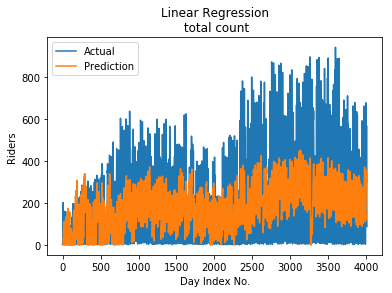

<module 'matplotlib.pyplot' from 'E:\Anaconda2\lib\site-packages\matplotlib\pyplot.pyc'>

In [56]:
# Plot
title='Linear Regression\n total count'
if title in lr_models:
    pass
else:
    lr_models[title]=lr_predict_zeros

plot_model(title,lr_predict_zeros)

In [57]:
# Predict the test set
lr_predict_test = linear_regression_model.predict(X=transformed_test[predictors])
lr_predict_zeros_test = zero_negatives(lr_predict_test)
CSV_Output(lr_predict_zeros_test,"lr_zeros")

Kaggle score: 1.32855

In [58]:
# Casual users
linear_regression_model_casual = LinearRegression()
linear_regression_model_casual.fit(transformed_train[predictors], casual_y_train['casual'].values)
lr_predict_casual = linear_regression_model_casual.predict(X=transformed_dev[predictors])
lr_predict_zeros_casual = zero_negatives(lr_predict_casual)

In [59]:
# Registered users
linear_regression_model_reg = LinearRegression()
linear_regression_model_reg.fit(transformed_train[predictors], reg_y_train['registered'].values)
lr_predict_reg = linear_regression_model_reg.predict(X=transformed_dev[predictors])
lr_predict_zeros_reg = zero_negatives(lr_predict_reg)

In [60]:
# Combine casual and registered predictions into a single count output
lr_predict_zeros_casual_reg = [sum(x) for x in zip(lr_predict_zeros_casual, lr_predict_zeros_reg)]

print 'RMSLE: {:.5}'.format(rmsle(count_y_dev['count'].values,lr_predict_zeros_casual_reg))
print '\nCoefficients (casual:registered):'
for i,p in enumerate(predictors):
    print '{:10} : {:.5} : {:.5}'.format(p,linear_regression_model_casual.coef_[i], linear_regression_model_reg.coef_[i])

print '\nCoefficients:'
for i,p in enumerate(predictors):
    print '{} : {:.5}'.format(p,linear_regression_model.coef_[i])


RMSLE: 1.2138

Coefficients (casual:registered):
hour       : 1.0879 : 6.4617
day        : -0.0068558 : 0.38125
month      : -0.83166 : 7.9453
year       : 6.9204 : 70.384
temp       : -12.196 : -45.768
atemp      : 32.407 : 75.872
humidity   : -15.537 : -24.216
windspeed  : 1.5041 : 7.8829
season     : 5.2637 : -2.0122
holiday    : -5.2661 : 0.29893
workingday : -36.103 : 37.856
weather    : 2.2785 : -7.4522

Coefficients:
hour : 7.5496
day : 0.37439
month : 7.1136
year : 77.305
temp : -57.964
atemp : 108.28
humidity : -39.753
windspeed : 9.387
season : 3.2515
holiday : -4.9672
workingday : 1.7534
weather : -5.1737


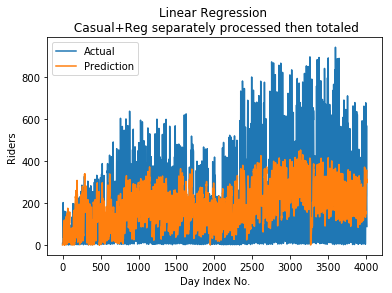

<module 'matplotlib.pyplot' from 'E:\Anaconda2\lib\site-packages\matplotlib\pyplot.pyc'>

In [61]:
# Plot
title="Linear Regression \n Casual+Reg separately processed then totaled"
if title in lr_models:
    pass
else:
    lr_models[title]=lr_predict_zeros_casual_reg

plot_model(title,lr_predict_zeros_casual_reg)

In [62]:
# Predict the test set
lr_predict_casual_test = linear_regression_model_casual.predict(X=transformed_test[predictors])
lr_predict_zeros_casual_test = zero_negatives(lr_predict_casual_test)
lr_predict_reg_test = linear_regression_model_reg.predict(X=transformed_test[predictors])
lr_predict_zeros_reg_test = zero_negatives(lr_predict_reg_test)
lr_predict_zeros_casual_reg_test = pd.Series([sum(x) for x in zip(lr_predict_zeros_casual_test, lr_predict_zeros_reg_test)])
CSV_Output(lr_predict_zeros_casual_reg_test,"lr_zeros_casual_reg")

Kaggle score: 1.28400

### Linear Regression log(y)

#### Calculate the log of the dependent value count

In [63]:
def log_variable(X):
    return np.log1p(X)
#    return np.log(X)

def exp_variable(X):
    return np.expm1(X)
#    return np.exp(X)

log_y_train = log_variable(count_y_train)
log_y_train_casual = log_variable(casual_y_train)
log_y_train_reg = log_variable(reg_y_train)


#### Linear regression model using log(y)

In [64]:
# Using the total count
log_linear_regression_model = LinearRegression()
log_linear_regression_model.fit(transformed_train[predictors], log_y_train['count'].values)
log_lr_predict = log_linear_regression_model.predict(X=transformed_dev[predictors])
exp_log_lr_predict = exp_variable(log_lr_predict)

print 'RMSLE: {:.5}'.format(rmsle(count_y_dev['count'].values,exp_log_lr_predict))
print '\nCoefficients:'
for i,p in enumerate(predictors):
    print '{} : {:.5}'.format(p,log_linear_regression_model.coef_[i])


RMSLE: 1.025

Coefficients:
hour : 0.096806
day : 0.00026665
month : 0.055176
year : 0.40888
temp : -0.40577
atemp : 0.75805
humidity : -0.29377
windspeed : 0.06042
season : 0.028919
holiday : -0.059778
workingday : -0.09113
weather : -0.015903


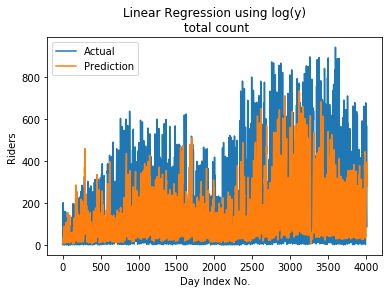

<module 'matplotlib.pyplot' from 'E:\Anaconda2\lib\site-packages\matplotlib\pyplot.pyc'>

In [65]:
# Plot
title='Linear Regression using log(y)\n total count'
if title in lr_models:
    pass
else:
    lr_models[title]=exp_log_lr_predict
    
plot_model(title,exp_log_lr_predict)

In [66]:
# Predict the test set
log_lr_predict_test = log_linear_regression_model.predict(X=transformed_test[predictors])
exp_log_lr_predict_test = exp_variable(log_lr_predict_test)
CSV_Output(exp_log_lr_predict_test,"lr_log")

Kaggle score: 1.03834

In [67]:
#casual users
log_linear_regression_model_casual = LinearRegression()
log_linear_regression_model_casual.fit(transformed_train[predictors], log_y_train_casual['casual'].values)
log_lr_predict_casual = log_linear_regression_model_casual.predict(X=transformed_dev[predictors])
exp_log_lr_predict_casual = exp_variable(log_lr_predict_casual)

#registered users
log_linear_regression_model_reg = LinearRegression()
log_linear_regression_model_reg.fit(transformed_train[predictors], log_y_train_reg['registered'].values)
log_lr_predict_reg = log_linear_regression_model_reg.predict(X=transformed_dev[predictors])
exp_log_lr_predict_reg = exp_variable(log_lr_predict_reg)

In [68]:
# Combine casual and registered predictions into a single count output
exp_log_lr_predict_casual_reg = [sum(x) for x in zip(exp_log_lr_predict_casual, exp_log_lr_predict_reg)]

print 'RMSLE: {:.5}'.format(rmsle(count_y_dev['count'].values,exp_log_lr_predict_casual_reg))
print '\nCoefficients (casual:registered):'
for i,p in enumerate(predictors):
    print '{:10} : {:.5} : {:.5}'.format(p,log_linear_regression_model_casual.coef_[i], log_linear_regression_model_reg.coef_[i])


RMSLE: 1.0221

Coefficients (casual:registered):
hour       : 0.072449 : 0.098178
day        : -0.0037329 : 0.0014997
month      : 0.0056412 : 0.067698
year       : 0.17742 : 0.45213
temp       : -0.64763 : -0.35922
atemp      : 1.3487 : 0.63437
humidity   : -0.40456 : -0.263
windspeed  : 0.084346 : 0.057073
season     : 0.13962 : -0.0036907
holiday    : -0.18746 : -0.046437
workingday : -0.74662 : 0.060714
weather    : -0.017537 : -0.01698


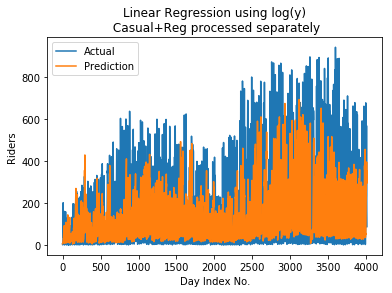

<module 'matplotlib.pyplot' from 'E:\Anaconda2\lib\site-packages\matplotlib\pyplot.pyc'>

In [69]:
# Plot
title='Linear Regression using log(y)\n Casual+Reg processed separately'
if title in lr_models:
    pass
else:
    lr_models[title]=exp_log_lr_predict_casual_reg

plot_model(title,exp_log_lr_predict_casual_reg)

In [58]:
# Predict the test set
log_lr_predict_casual_test = log_linear_regression_model_casual.predict(X=transformed_test[predictors])
exp_log_lr_predict_casual_test = exp_variable(log_lr_predict_casual_test)
log_lr_predict_reg_test = log_linear_regression_model_reg.predict(X=transformed_test[predictors])
exp_log_lr_predict_reg_test = exp_variable(log_lr_predict_reg_test)
exp_log_lr_predict_casual_reg_test = pd.Series([sum(x) for x in zip(exp_log_lr_predict_casual_test, exp_log_lr_predict_reg_test)])

CSV_Output(exp_log_lr_predict_reg_test,"lr_log_casual_reg")

Kaggle score: 1.06305

#### Linear Regression observations
Using the log of the y variable resulted in a better fit. We will continue to use log(y) in further models.<p>
There is a slight improvement using the split casual/regsitered models. The coefficients show that there is a clear difference in the importance of the features when predicting casual vs registered counts. For instance, working day is positive for registered and negative for casual; temperature overall has a higher effect on casual than registered; and hour has a greater impact on registered than casual.<p>
The models appear to be compensating for the two correlated temperature values by making one of the coefficients negative and the other positive.<p>
Year has a strong influence. It looks like there was an overall increase in bike sharing usage in the second year of the data set.

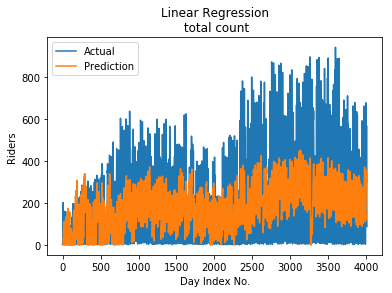

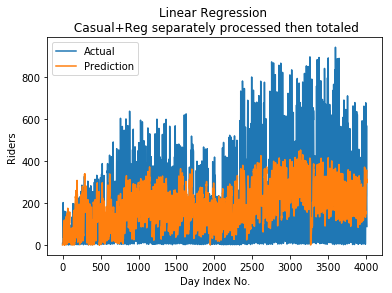

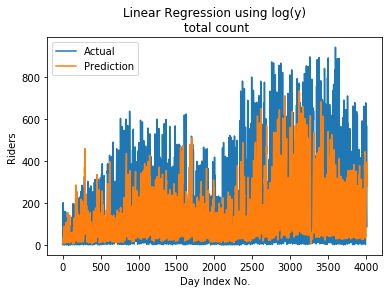

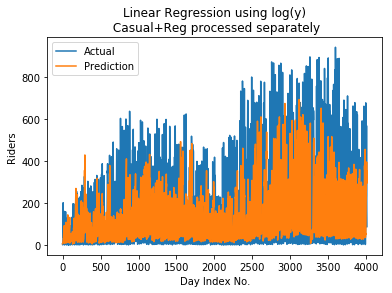

In [70]:
#Combined plot
j=0
for i in lr_models:
    j=j+1
    plot=plot_model(i,lr_models[i])  


### Regularization

Regularization addresses overfitting by penalizing additional complexity in the model. Each regularization model has an alpha value which specifies the strength of the penalty applied for model complexity. As the value of alpha increases, the model complexity reduces, along with the risk of overfitting. We performed cross validation experiments to determine the best values for alpha for each model.

In [71]:
regularization_models={}

### Ridge

Ridge regression performs L2 regularization, which adds a factor of the sum of squares of the coefficients in the likelihood calculation.

In [72]:
alphas = [1, 5, 10, 50, 100, 200, 500]


In [73]:
# Using the total count
ridge_grid_search = RidgeCV(alphas=alphas, scoring = rmsle_scorer, cv=5)
ridge_grid_search.fit(transformed_train[predictors], log_y_train['count'].values)
print 'alpha: {}'.format(ridge_grid_search.alpha_)

log_ridge_predict = ridge_grid_search.predict(X=transformed_dev[predictors])
exp_log_ridge_predict = exp_variable(log_ridge_predict)

print 'RMSLE: {:.5}'.format(rmsle(count_y_dev['count'].values,exp_log_ridge_predict))
print '\nCoefficients:'
for i,p in enumerate(predictors):
    print '{} : {:.5}'.format(p,ridge_grid_search.coef_[i])


alpha: 1
RMSLE: 1.0245

Coefficients:
hour : 0.096817
day : 0.00026118
month : 0.055173
year : 0.40883
temp : -0.39332
atemp : 0.74554
humidity : -0.29359
windspeed : 0.059947
season : 0.028965
holiday : -0.059908
workingday : -0.091081
weather : -0.015999


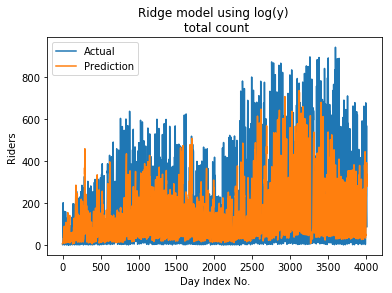

<module 'matplotlib.pyplot' from 'E:\Anaconda2\lib\site-packages\matplotlib\pyplot.pyc'>

In [74]:
# Plot
title='Ridge model using log(y) \n total count'
if title in regularization_models:
    pass
else:
    regularization_models[title]=exp_log_ridge_predict

plot_model(title,exp_log_ridge_predict)

In [75]:
# Predict the test set
log_ridge_predict_test = ridge_grid_search.predict(X=transformed_test[predictors])
exp_log_ridge_predict_test = exp_variable(log_ridge_predict_test)
CSV_Output(exp_log_ridge_predict_test,"ridge")

Kaggle score: 1.03834

In [76]:
#casual users
ridge_grid_search_casual = RidgeCV(alphas=alphas, scoring = rmsle_scorer, cv=5)
ridge_grid_search_casual.fit(transformed_train[predictors], log_y_train_casual['casual'].values)
print 'alpha casual: {}'.format(ridge_grid_search_casual.alpha_)

log_ridge_predict_casual = ridge_grid_search_casual.predict(X=transformed_dev[predictors])
exp_log_ridge_predict_casual = exp_variable(log_ridge_predict_casual)

#registered users
ridge_grid_search_reg = RidgeCV(alphas=alphas, scoring = rmsle_scorer, cv=5)
ridge_grid_search_reg.fit(transformed_train[predictors], log_y_train_reg['registered'].values)
print 'alpha registered: {}'.format(ridge_grid_search_reg.alpha_)

log_ridge_predict_reg = ridge_grid_search_reg.predict(X=transformed_dev[predictors])
exp_log_ridge_predict_reg = exp_variable(log_ridge_predict_reg)

alpha casual: 1
alpha registered: 1


In [77]:
# Combine casual and registered predictions into a single count output
exp_log_ridge_predict_casual_reg = [sum(x) for x in zip(exp_log_ridge_predict_casual, exp_log_ridge_predict_reg)]

print 'RMSLE: {:.5}'.format(rmsle(count_y_dev['count'].values,exp_log_ridge_predict_casual_reg))
print '\nCoefficients (casual:registered):'
for i,p in enumerate(predictors):
    print '{:10} : {:.5} : {:.5}'.format(p,ridge_grid_search_casual.coef_[i], ridge_grid_search_reg.coef_[i])


RMSLE: 1.0217

Coefficients (casual:registered):
hour       : 0.07247 : 0.098187
day        : -0.0037429 : 0.0014951
month      : 0.0057281 : 0.06767
year       : 0.17764 : 0.45202
temp       : -0.62629 : -0.34859
atemp      : 1.3272 : 0.62369
humidity   : -0.40424 : -0.26285
windspeed  : 0.083521 : 0.056671
season     : 0.13941 : -0.0035738
holiday    : -0.18692 : -0.046649
workingday : -0.74607 : 0.060652
weather    : -0.017721 : -0.017056


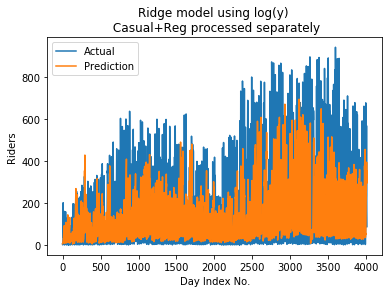

<module 'matplotlib.pyplot' from 'E:\Anaconda2\lib\site-packages\matplotlib\pyplot.pyc'>

In [78]:
# Plot
title='Ridge model using log(y) \n Casual+Reg processed separately'
if title in regularization_models:
    pass
else:
    regularization_models[title]=exp_log_ridge_predict_casual_reg
plot_model(title,exp_log_ridge_predict_casual_reg)

In [68]:
# Predict the test set
log_ridge_predict_casual_test = ridge_grid_search_casual.predict(X=transformed_test[predictors])
exp_log_ridge_predict_casual_test = exp_variable(log_ridge_predict_casual_test)
log_ridge_predict_reg_test = ridge_grid_search_reg.predict(X=transformed_test[predictors])
exp_log_ridge_predict_reg_test = exp_variable(log_ridge_predict_reg_test)
exp_log_ridge_predict_casual_reg_test = pd.Series([sum(x) for x in zip(exp_log_ridge_predict_casual_test, exp_log_ridge_predict_reg_test)])
CSV_Output(exp_log_ridge_predict_casual_reg_test,"ridge_casual_reg")

Kaggle score: 1.04124

### Lasso

Lasso regression performs L1 regularization, which adds a factor of the sum of the absolute values of the coefficients in the likelihood calculation.


In [79]:
alphas = 2. ** np.arange(-10, 10)


In [80]:
# Using the total count
lasso_grid_search = LassoCV(alphas=alphas, cv=5)
lasso_grid_search.fit(transformed_train[predictors], log_y_train['count'].values)
print 'alpha: {}'.format(lasso_grid_search.alpha_)

log_lasso_predict = lasso_grid_search.predict(X=transformed_dev[predictors])
exp_log_lasso_predict = exp_variable(log_lasso_predict)


print 'RMSLE: {:.5}'.format(rmsle(count_y_dev['count'].values,exp_log_lasso_predict))
print '\nCoefficients:'
for i,p in enumerate(predictors):
    print '{} : {:.5}'.format(p,lasso_grid_search.coef_[i])


alpha: 0.0009765625
RMSLE: 1.0195

Coefficients:
hour : 0.096921
day : 0.00013558
month : 0.058553
year : 0.40691
temp : -0.25852
atemp : 0.61063
humidity : -0.29206
windspeed : 0.053459
season : 0.017675
holiday : -0.025172
workingday : -0.083435
weather : -0.014502


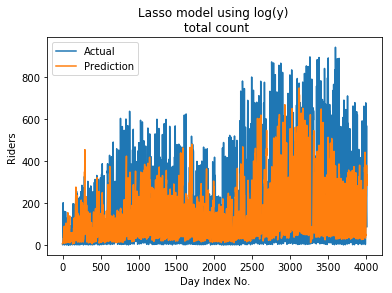

<module 'matplotlib.pyplot' from 'E:\Anaconda2\lib\site-packages\matplotlib\pyplot.pyc'>

In [81]:
title='Lasso model using log(y) \n total count'
if title in lr_models:
    pass
else:
    lr_models[title]=exp_log_lasso_predict
plot_model(title,exp_log_lasso_predict)

In [72]:
# Predict the test set
log_lasso_predict_test = lasso_grid_search.predict(X=transformed_test[predictors])
exp_log_lasso_predict_test = exp_variable(log_lasso_predict_test)
CSV_Output(exp_log_lasso_predict_test,"lasso")

Kaggle score: 1.03992

In [82]:
#casual users
lasso_grid_search_casual = LassoCV(alphas=alphas, cv=5)
lasso_grid_search_casual.fit(transformed_train[predictors], log_y_train_casual['casual'].values)
print 'alpha: {}'.format(lasso_grid_search.alpha_)

log_lasso_predict_casual = lasso_grid_search_casual.predict(X=transformed_dev[predictors])
exp_log_lasso_predict_casual = exp_variable(log_lasso_predict_casual)

#registered users
lasso_grid_search_reg = LassoCV(alphas=alphas, cv=5)
lasso_grid_search_reg.fit(transformed_train[predictors], log_y_train_reg['registered'].values)
print 'alpha: {}'.format(lasso_grid_search.alpha_)

log_lasso_predict_reg = lasso_grid_search_reg.predict(X=transformed_dev[predictors])
exp_log_lasso_predict_reg = exp_variable(log_lasso_predict_reg)

alpha: 0.0009765625
alpha: 0.0009765625


In [83]:
# Combine casual and registered predictions into a single count output
exp_log_lasso_predict_casual_reg = [sum(x) for x in zip(exp_log_lasso_predict_casual, exp_log_lasso_predict_reg)]

print 'RMSLE: {:.5}'.format(rmsle(count_y_dev['count'].values,exp_log_lasso_predict_casual_reg))
print '\nCoefficients:'
for i,p in enumerate(predictors):
    print '{:10} : {:.5} : {:.5}'.format(p,lasso_grid_search_casual.coef_[i], lasso_grid_search_reg.coef_[i])


RMSLE: 1.017

Coefficients:
hour       : 0.072564 : 0.098284
day        : -0.0036994 : 0.0013746
month      : 0.0090152 : 0.066399
year       : 0.17544 : 0.45014
temp       : -0.50033 : -0.21089
atemp      : 1.2012 : 0.48577
humidity   : -0.40284 : -0.26147
windspeed  : 0.07737 : 0.050366
season     : 0.12837 : -0.0
holiday    : -0.15288 : -0.020934
workingday : -0.73893 : 0.058563
weather    : -0.016109 : -0.015199


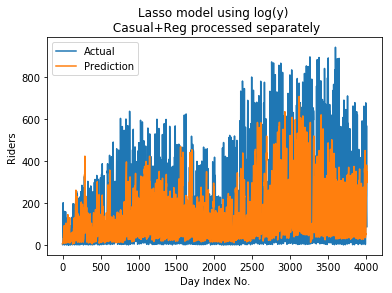

<module 'matplotlib.pyplot' from 'E:\Anaconda2\lib\site-packages\matplotlib\pyplot.pyc'>

In [84]:
title='Lasso model using log(y) \n Casual+Reg processed separately'
if title in regularization_models:
    pass
else:
    regularization_models[title]=exp_log_lasso_predict_casual_reg

plot_model(title,exp_log_lasso_predict_casual_reg)

In [76]:
# Predict the test set
log_lasso_predict_casual_test = lasso_grid_search_casual.predict(X=transformed_test[predictors])
exp_log_lasso_predict_casual_test = exp_variable(log_lasso_predict_casual_test)
log_lasso_predict_reg_test = lasso_grid_search_reg.predict(X=transformed_test[predictors])
exp_log_lasso_predict_reg_test = exp_variable(log_lasso_predict_reg_test)
exp_log_lasso_predict_casual_reg_test = pd.Series([sum(x) for x in zip(exp_log_lasso_predict_casual_test, exp_log_lasso_predict_reg_test)])
CSV_Output(exp_log_lasso_predict_casual_reg_test,"lasso_casual_reg")

Kaggle score: 1.04047

### Elastic Net

ElasticNet regression performs a combination of L1 and L2 regularization. The combination of L1 and L2 is controlled by the l1_ratio parameter. We used cross validation experiments to determine the best values for l1_ratio as well as the regularization strength alpha.

In [86]:
alphas = 2. ** np.arange(-10, 10)
l1_ratio = np.linspace(.05, .95, 20)

In [87]:
# Using the total count
elastic_grid_search = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratio, cv=5)
elastic_grid_search.fit(transformed_train[predictors], log_y_train['count'].values)
print 'alpha: {}'.format(elastic_grid_search.alpha_)
print 'l1_ratio: {}'.format(elastic_grid_search.l1_ratio_)

log_elastic_predict = elastic_grid_search.predict(X=transformed_dev[predictors])
exp_log_elastic_predict = exp_variable(log_elastic_predict)


print 'RMSLE: {:.5}'.format(rmsle(count_y_dev['count'].values,exp_log_elastic_predict))
print '\nCoefficients:'
for i,p in enumerate(predictors):
    print '{} : {:.5}'.format(p,elastic_grid_search.coef_[i])


alpha: 0.0009765625
l1_ratio: 0.0973684210526
RMSLE: 1.0219

Coefficients:
hour : 0.096878
day : 0.00022474
month : 0.055489
year : 0.40824
temp : -0.32503
atemp : 0.67697
humidity : -0.29259
windspeed : 0.057224
season : 0.028056
holiday : -0.056923
workingday : -0.090061
weather : -0.016296


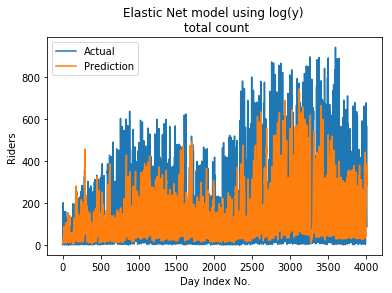

<module 'matplotlib.pyplot' from 'E:\Anaconda2\lib\site-packages\matplotlib\pyplot.pyc'>

In [88]:
title='Elastic Net model using log(y) \n total count'
if title in regularization_models:
    pass
else:
    regularization_models[title]=exp_log_elastic_predict

plot_model(title,exp_log_elastic_predict)

In [80]:
# Predict the test set
log_elastic_predict_test = elastic_grid_search.predict(X=transformed_test[predictors])
exp_log_elastic_predict_test = exp_variable(log_elastic_predict_test)
CSV_Output(exp_log_elastic_predict_test,"elastic")

Kaggle score: 1.03811

In [89]:
# casual users
elastic_grid_search_casual = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratio, cv=5)
elastic_grid_search_casual.fit(transformed_train[predictors], log_y_train_casual['casual'].values)
print 'casual alpha: {}'.format(elastic_grid_search_casual.alpha_)
print 'casual l1_ratio: {}'.format(elastic_grid_search_casual.l1_ratio_)

log_elastic_predict_casual = elastic_grid_search_casual.predict(X=transformed_dev[predictors])
exp_log_elastic_predict_casual = exp_variable(log_elastic_predict_casual)


# registered users
elastic_grid_search_reg = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratio, cv=5)
elastic_grid_search_reg.fit(transformed_train[predictors], log_y_train_reg['registered'].values)
print 'registered alpha: {}'.format(elastic_grid_search_reg.alpha_)
print 'registered l1_ratio: {}'.format(elastic_grid_search_casual.l1_ratio_)

log_elastic_predict_reg = elastic_grid_search_reg.predict(X=transformed_dev[predictors])
exp_log_elastic_predict_reg = exp_variable(log_elastic_predict_reg)


casual alpha: 0.0009765625
casual l1_ratio: 0.05
registered alpha: 0.0009765625
registered l1_ratio: 0.05


In [90]:
# Combine casual and registered predictions into a single count output
exp_log_elastic_predict_casual_reg = [sum(x) for x in zip(exp_log_elastic_predict_casual, exp_log_elastic_predict_reg)]

print 'RMSLE: {:.5}'.format(rmsle(count_y_dev['count'].values,exp_log_elastic_predict_casual_reg))
print '\nCoefficients:'
for i,p in enumerate(predictors):
    print '{:10} : {:.5} : {:.5}'.format(p,elastic_grid_search_casual.coef_[i], elastic_grid_search_reg.coef_[i])


RMSLE: 1.0173

Coefficients:
hour       : 0.072574 : 0.098278
day        : -0.0037885 : 0.0013846
month      : 0.0063695 : 0.066417
year       : 0.1785 : 0.45024
temp       : -0.51913 : -0.22021
atemp      : 1.2194 : 0.49508
humidity   : -0.40256 : -0.26154
windspeed  : 0.079316 : 0.050831
season     : 0.13764 : -0.0
holiday    : -0.18186 : -0.023606
workingday : -0.74267 : 0.058729
weather    : -0.018552 : -0.015412


In [ ]:
title='Elastic Net model using log(y) \n Casual+Reg processed separately'
if title in regularization_models:
    pass
else:
    regularization_models[title]=exp_log_elastic_predict_casual_reg

plot_model(title,exp_log_elastic_predict_casual_reg)

In [128]:
# Predict the test set
log_elastic_predict_casual_test = elastic_grid_search_casual.predict(X=transformed_test[predictors])
exp_log_elastic_predict_casual_test = exp_variable(log_elastic_predict_casual_test)
log_elastic_predict_reg_test = elastic_grid_search_reg.predict(X=transformed_test[predictors])
exp_log_elastic_predict_reg_test = exp_variable(log_elastic_predict_reg_test)
exp_log_elastic_predict_casual_reg_test = pd.Series([sum(x) for x in zip(exp_log_elastic_predict_casual_test, exp_log_elastic_predict_reg_test)])
CSV_Output(exp_log_elastic_predict_casual_reg_test,"elastic_casual_reg")

Kaggle score: 1.11762

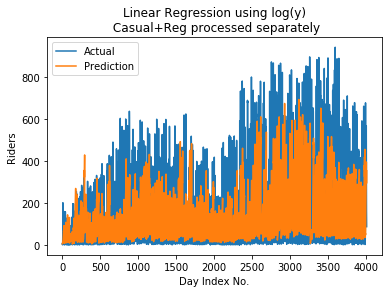

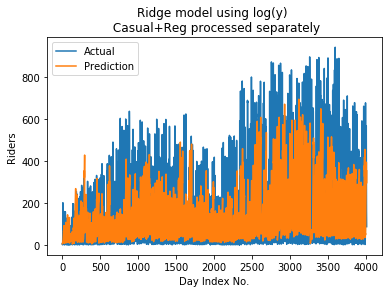

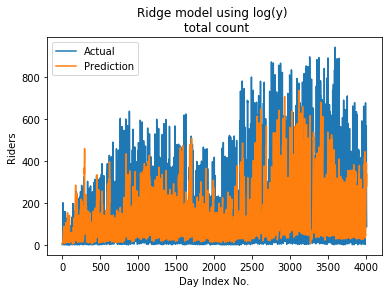

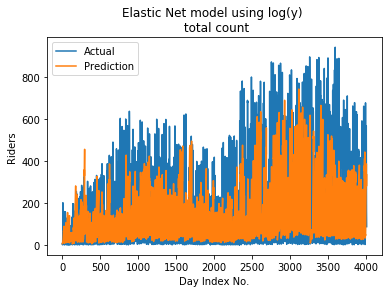

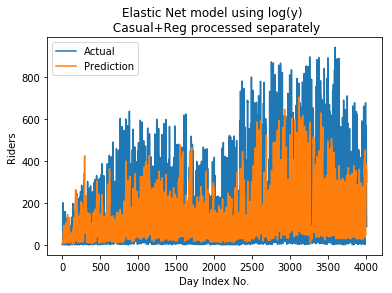

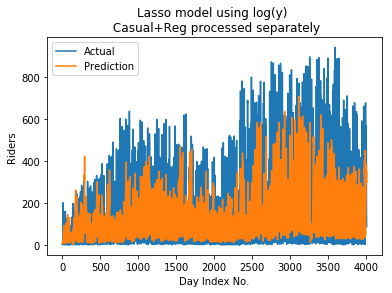

In [129]:
j=0
plot_model('Linear Regression using log(y)\n Casual+Reg processed separately',lr_models['Linear Regression using log(y)\n Casual+Reg processed separately'])
for i in regularization_models:
    j=j+1
    plot=plot_model(i,regularization_models[i])

### Observations

Comparing the Linear Regression model, with the Ridge, Lasso and ElasticNet regularization models, it was the Ridge and Lasso models which performed best. We did not see much improvement with regularization over the log(y) linear regression model. In each case the regularization strength selected by cross validation was small. Reducing complexity by penalizing the size of the coefficients is less effective when the coefficients are already small from using the log(y) transform.

### Decision Tree Regressor

Decision trees build a model by learning simple decision rules. The regressor works similarly to the classifier using numeric values.<p>
If a tree becomes overly complex there is a risk of overfitting. The max_depth controls the maximum depth of the tree and min_samples_split controls the minimum number of samples required to split an internal node. We used cross validation experiments to obtain parameter values which balance the complexity of the tree against overfitting.

In [130]:
dt_models={}

In [131]:
search_params_tree = {
    'max_depth': [10, 11, 12, 13, 14, 15],
    'min_samples_split': [2, 10, 100, 1000]
}

decision_tree_regressor = DecisionTreeRegressor()

In [132]:
# Using the total count
dt_grid_search = GridSearchCV(decision_tree_regressor, search_params_tree, scoring = rmsle_scorer, cv=5)
dt_grid_search.fit(transformed_train[predictors], log_y_train['count'].values)
print dt_grid_search.best_params_

log_dt_predict = dt_grid_search.predict(X=transformed_dev[predictors])
exp_log_dt_predict = exp_variable(log_dt_predict)

print rmsle(count_y_dev['count'].values,exp_log_dt_predict)

{'min_samples_split': 10, 'max_depth': 10}
0.477848996404


In [133]:
title='Decision Tree model using log(y) \n total count'
if title in dt_models:
    pass
else:
    dt_models[title]=exp_log_dt_predict

In [134]:
# Predict the test set
log_dt_predict_test = dt_grid_search.predict(X=transformed_test[predictors])
exp_log_dt_predict_test = exp_variable(log_dt_predict_test)
CSV_Output(exp_log_dt_predict_test,"tree")

Kaggle score: 0.54029

In [135]:
#casual users
dt_grid_search_casual = GridSearchCV(decision_tree_regressor, search_params_tree, scoring = rmsle_scorer, cv=5)
dt_grid_search_casual.fit(transformed_train[predictors], log_y_train_casual['casual'].values)
print dt_grid_search_casual.best_params_

log_dt_predict_casual = dt_grid_search_casual.predict(X=transformed_dev[predictors])
exp_log_dt_predict_casual = exp_variable(log_dt_predict_casual)

#registered users
dt_grid_search_reg = GridSearchCV(decision_tree_regressor, search_params_tree, scoring = rmsle_scorer, cv=5)
dt_grid_search_reg.fit(transformed_train[predictors], log_y_train_reg['registered'].values)
print dt_grid_search_reg.best_params_

log_dt_predict_reg = dt_grid_search_reg.predict(X=transformed_dev[predictors])
exp_log_dt_predict_reg = exp_variable(log_dt_predict_reg)

{'min_samples_split': 100, 'max_depth': 10}
{'min_samples_split': 10, 'max_depth': 10}


0.430621017913


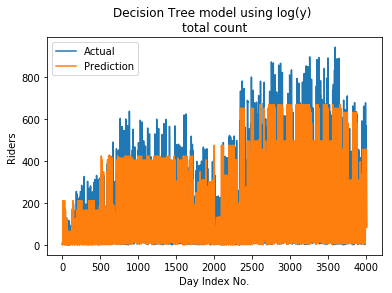

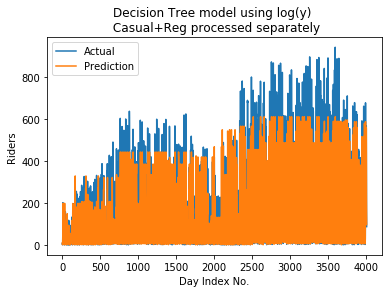

<module 'matplotlib.pyplot' from '/Users/charlotte/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [136]:
# Combine casual and registered predictions into a single count output
exp_log_dt_predict_casual_reg = [sum(x) for x in zip(exp_log_dt_predict_casual, exp_log_dt_predict_reg)]

title='Decision Tree model using log(y) \n Casual+Reg processed separately'
if title in dt_models:
    pass
else:
    dt_models[title]=exp_log_dt_predict_casual_reg

print rmsle(count_y_dev['count'].values,exp_log_dt_predict_casual_reg)

plot_model('Decision Tree model using log(y) \ntotal count',exp_log_dt_predict)
plot_model(title,exp_log_dt_predict_casual_reg)

In [137]:
# Predict the test set
log_dt_predict_casual_test = dt_grid_search_casual.predict(X=transformed_test[predictors])
exp_log_dt_predict_casual_test = exp_variable(log_dt_predict_casual_test)
log_dt_predict_reg_test = dt_grid_search_reg.predict(X=transformed_test[predictors])
exp_log_dt_predict_reg_test = exp_variable(log_dt_predict_reg_test)
exp_log_dt_predict_casual_reg_test = pd.Series([sum(x) for x in zip(exp_log_dt_predict_casual_test, exp_log_dt_predict_reg_test)])
CSV_Output(exp_log_dt_predict_casual_reg_test,"tree_casual_reg")

Kaggle score: 0.53353

insights fo effectiveness:
This may have been effective because of binned categorical features (weekday y/n) but may have benefited from further bins. i.e. rain, yes/no, temp above a certain marker, etc..
BUT it returns a class, primarily. this class may have been "good day (weather) vs bad day" or good day "weekend" vs bad day. this is when the casual/registered split becomes more powerful, as it enables the DT to focus on the weather and the day of the week as separate categories, whereas in the count metric they send mixed signals, and weekdays/rush hour may have as much total traffic as weekends. Furthermore the regressor can better evaluate conditions that make the casual user total less, while the registered user remains unaffected. Separating Casual and registered already chooses an attribute, but by filtering the data at the outset

### Random Forest Regressor

A random forest fits a number of decision trees on sub-samples of the dataset and uses averaging to improve predictive accuracy and control over-fitting. <p> We used 100 trees (estimators) in our forest which was as large as we could manage in our computing environments. We used the full number of features in our subsets as recommended for regression problems. As with decision trees, used cross validation experiments to obtain parameter values for max_depth and min_samples_split.

In [138]:
search_params_forest = {
    'max_depth': [10, 11, 12, 13, 14, 15],
    'min_samples_split': [2, 10, 100, 1000]
}

random_forest_regressor = RandomForestRegressor(n_estimators=100)

In [139]:
# Using the total count
rf_grid_search = GridSearchCV(random_forest_regressor, search_params_forest, scoring = rmsle_scorer, cv=5)
rf_grid_search.fit(transformed_train[predictors], log_y_train['count'].values)
print rf_grid_search.best_params_

log_rf_predict = rf_grid_search.predict(X=transformed_dev[predictors])
exp_log_rf_predict = exp_variable(log_rf_predict)

print rmsle(count_y_dev['count'].values,exp_log_rf_predict)

{'min_samples_split': 2, 'max_depth': 13}
0.3542175769


In [140]:
title='Random Forest model using log(y)\ntotal count'
if title in dt_models:
    pass
else:
    dt_models[title]=exp_log_rf_predict


In [141]:
# Predict the test set
log_rf_predict_test = rf_grid_search.predict(X=transformed_test[predictors])
exp_log_rf_predict_test = exp_variable(log_rf_predict_test)
CSV_Output(exp_log_rf_predict_test,"forest")

Kaggle score: 0.44867

Random Forest averages out the overfitting tendency of the Decision tree model, making it more reliable for the test set. Especially because the weather tends to be a stronger factor than the actual date, overfitting to just weather features would lose the flexibility of seasonal data. 

In [142]:
#casual users
rf_grid_search_casual = GridSearchCV(random_forest_regressor, search_params_forest, scoring = rmsle_scorer, cv=5)
rf_grid_search_casual.fit(transformed_train[predictors], log_y_train_casual['casual'].values)
print rf_grid_search_casual.best_params_

log_rf_predict_casual = rf_grid_search_casual.predict(X=transformed_dev[predictors])
exp_log_rf_predict_casual = exp_variable(log_rf_predict_casual)

#registered users
rf_grid_search_reg = GridSearchCV(random_forest_regressor, search_params_forest, scoring = rmsle_scorer, cv=5)
rf_grid_search_reg.fit(transformed_train[predictors], log_y_train_reg['registered'].values)
print rf_grid_search_reg.best_params_

log_rf_predict_reg = rf_grid_search_reg.predict(X=transformed_dev[predictors])
exp_log_rf_predict_reg = exp_variable(log_rf_predict_reg)

{'min_samples_split': 10, 'max_depth': 10}
{'min_samples_split': 2, 'max_depth': 14}


In [143]:
# Combine casual and registered predictions into a single count output
exp_log_rf_predict_casual_reg = [sum(x) for x in zip(exp_log_rf_predict_casual, exp_log_rf_predict_reg)]

print rmsle(count_y_dev['count'].values,exp_log_rf_predict_casual_reg)

0.344622142229


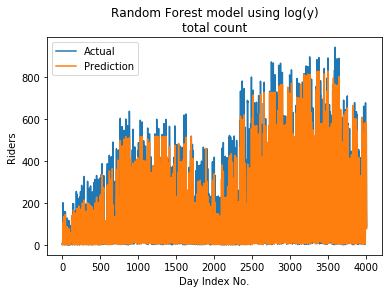

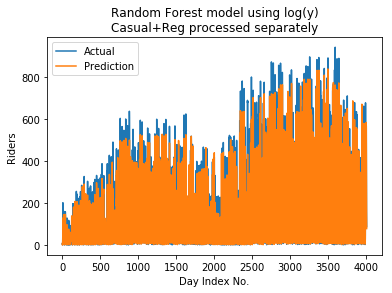

<module 'matplotlib.pyplot' from '/Users/charlotte/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [144]:
# Plot
title='Random Forest model using log(y)\nCasual+Reg processed separately'
if title in dt_models:
    pass
else:
    dt_models[title]=exp_log_rf_predict_casual_reg

plot_model('Random Forest model using log(y)\ntotal count',exp_log_rf_predict)
plot_model(title,exp_log_rf_predict_casual_reg)

In [145]:
# Predict the test set
log_rf_predict_casual_test = rf_grid_search_casual.predict(X=transformed_test[predictors])
exp_log_rf_predict_casual_test = exp_variable(log_rf_predict_casual_test)
log_rf_predict_reg_test = rf_grid_search_reg.predict(X=transformed_test[predictors])
exp_log_rf_predict_reg_test = exp_variable(log_rf_predict_reg_test)
exp_log_rf_predict_casual_reg_test = pd.Series([sum(x) for x in zip(exp_log_rf_predict_casual_test, exp_log_rf_predict_reg_test)])
CSV_Output(exp_log_rf_predict_casual_reg_test,"forest_casual_reg")

Kaggle score: 0.44636

### Gradient Boosting Regressor

Gradient boosting regression iteratively combines weak learners into a single strong learner. In each stage a regression tree is fit on the negative gradient of the given loss function.<p>We used least squares as our loss function which is the default for regression. Once again we used 100 estimators which stretched our computation power to its limits. As with decision trees and forests, we used cross validation experiments to obtain parameter values for max_depth and min_samples_split.

In [146]:
search_params_gradient_boost = {
    'max_depth': [10, 11, 12, 13, 14, 15],
    'min_samples_split': [2, 10, 100, 1000]
}

gradient_boost_regressor = GradientBoostingRegressor(n_estimators=100)

In [147]:
# Using the total count
gradient_boost_grid_search = GridSearchCV(gradient_boost_regressor, search_params_gradient_boost, scoring = rmsle_scorer, cv=5)
gradient_boost_grid_search.fit(transformed_train[predictors], log_y_train['count'].values)
print gradient_boost_grid_search.best_params_

log_gradient_boost_predict = gradient_boost_grid_search.predict(X=transformed_dev[predictors])
exp_log_gradient_boost_predict = exp_variable(log_gradient_boost_predict)

print rmsle(count_y_dev['count'].values,exp_log_gradient_boost_predict)

{'min_samples_split': 100, 'max_depth': 11}
0.346425954455


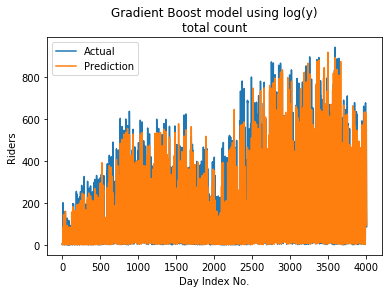

<module 'matplotlib.pyplot' from '/Users/charlotte/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [148]:
title='Gradient Boost model using log(y)\ntotal count'
if title in dt_models:
    pass
else:
    dt_models[title]=exp_log_gradient_boost_predict
    
plot_model(title,exp_log_gradient_boost_predict)

In [149]:
# Predict the test set
log_gradient_boost_predict_test = gradient_boost_grid_search.predict(X=transformed_test[predictors])
exp_log_gradient_boost_predict_test = exp_variable(log_gradient_boost_predict_test)
CSV_Output(exp_log_gradient_boost_predict_test,"gradient")

Kaggle score: 0.44026

In [150]:
#casual users
gradient_boost_grid_search_casual = GridSearchCV(gradient_boost_regressor, search_params_gradient_boost, scoring = rmsle_scorer, cv=5)
gradient_boost_grid_search_casual.fit(transformed_train[predictors], log_y_train_casual['casual'].values)
print gradient_boost_grid_search_casual.best_params_

log_gradient_boost_predict_casual = gradient_boost_grid_search_casual.predict(X=transformed_dev[predictors])
exp_log_gradient_boost_predict_casual = exp_variable(log_gradient_boost_predict_casual)

#registered users
gradient_boost_grid_search_reg = GridSearchCV(gradient_boost_regressor, search_params_gradient_boost, scoring = rmsle_scorer, cv=5)
gradient_boost_grid_search_reg.fit(transformed_train[predictors], log_y_train_reg['registered'].values)
print rf_grid_search_reg.best_params_

log_gradient_boost_predict_reg = gradient_boost_grid_search_reg.predict(X=transformed_dev[predictors])
exp_log_gradient_boost_predict_reg = exp_variable(log_gradient_boost_predict_reg)

{'min_samples_split': 1000, 'max_depth': 12}
{'min_samples_split': 2, 'max_depth': 14}


0.344449452357


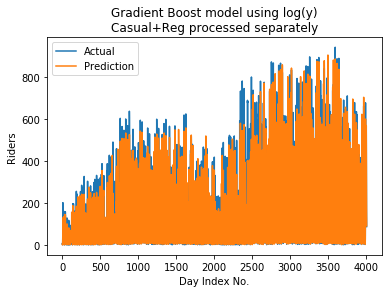

<module 'matplotlib.pyplot' from '/Users/charlotte/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [151]:
# Combine casual and registered predictions into a single count output
exp_log_gradient_boost_predict_casual_reg = [sum(x) for x in zip(exp_log_gradient_boost_predict_casual, exp_log_gradient_boost_predict_reg)]

title='Gradient Boost model using log(y)\nCasual+Reg processed separately'
if title in dt_models:
    pass
else:
    dt_models[title]=exp_log_gradient_boost_predict_casual_reg

print rmsle(count_y_dev['count'].values,exp_log_gradient_boost_predict_casual_reg)
plot_model(title,exp_log_gradient_boost_predict_casual_reg)

In [152]:
# Predict the test set
log_gradient_boost_predict_casual_test = gradient_boost_grid_search_casual.predict(X=transformed_test[predictors])
exp_log_gradient_boost_predict_casual_test = exp_variable(log_gradient_boost_predict_casual_test)
log_gradient_boost_predict_reg_test = gradient_boost_grid_search_reg.predict(X=transformed_test[predictors])
exp_log_gradient_boost_predict_reg_test = exp_variable(log_gradient_boost_predict_reg_test)
exp_log_gradient_boost_predict_casual_reg_test = pd.Series([sum(x) for x in zip(exp_log_gradient_boost_predict_casual_test, exp_log_gradient_boost_predict_reg_test)])
CSV_Output(exp_log_gradient_boost_predict_casual_reg_test,"gradient_casual_reg")

Kaggle score: 0.44704

### Observations

In our results we found that random forest performed better than decision tree; and gradient boost performed better than random forest. Our best overall results came from gradient boost regression. The ensemble method based on the performance of multiple trees worked better than a single tree. The gradient boost iterative gradient descent approach was more effective than the random forest averaging.

Gradient boosted training function builds stage wise using the decision tree model, but refines it by combining multiple weak decision trees and an optimised residual function. This way it can minimize the residual error across multiple decision trees, but still use the as a baseline model. The optimization of the residual may be more effective for classification problems instead of regression,however still strengthens the decision tree algorithm overall. 

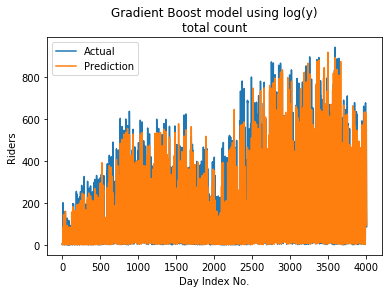

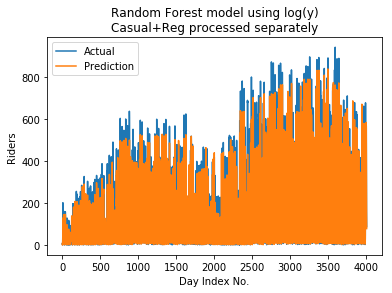

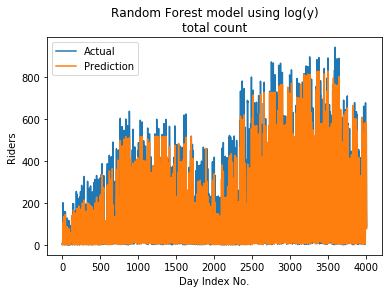

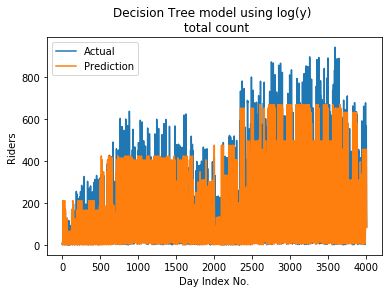

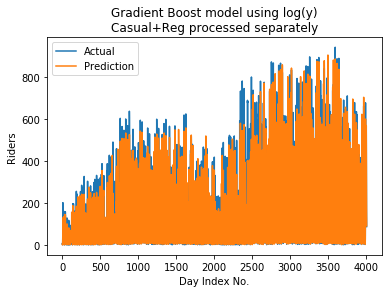

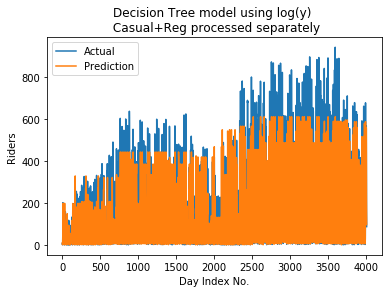

In [153]:
for i in dt_models:
    j=j+1
    plot=plot_model(i,dt_models[i])